# Ranking comparison and timing

In [27]:
%load_ext autoreload
%autoreload 2

import math  # noqa
import sys  # noqa
import time  # noqa

import matplotlib.pyplot as plt  # noqa
import numpy as np  # noqa
import pandas as pd  # noqa
import seaborn as sns  # noqa

sys.path.append("..")

from backend.llm.ranking import CHOIX_RANKER_ALGORITHMS, Battle, ChoixRanker, EloRanker, NaiveRanker  # noqa: E402

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The LS dataset can be downloaded using:

```sh
git lfs install
git clone git@hf.co:datasets/lmsys/lmsys-chat-1m
git clone git@hf.co:datasets/lmsys/lmsys-arena-human-preference-55k
```

This requires accepting the TOS for that dataset and adding an ssh key to https://huggingface.co/settings/keys.

In [20]:
# Load LS data; change the path the directory containing the dataset downloaded above.
df = pd.read_csv("../../lmsys-arena-human-preference-55k/train.csv")


# The original LS code references a "winner" column, but this is not in the dataset, add it here.
def get_winner(row):
    if row["winner_tie"] == 1:
        return "tie"
    elif row["winner_model_a"] == 1:
        return "model_a"
    elif row["winner_model_b"] == 1:
        return "model_b"
    raise ValueError(f"Unknown winner: {row['winner_model_a']}, {row['winner_model_b']}, {row['winner_tie']}")


df["winner"] = df.apply(get_winner, axis=1)
df.head(3)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,model_a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,model_b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,tie


In [21]:
# Convert the dataset to a list of battles, our internal representation.
def row_to_battle(row):
    if row.winner_model_b == 1:
        result = 0
    elif row.winner_model_a == 1:
        result = 1
    elif row.winner_tie == 1:
        result = 0.5
    else:
        raise ValueError(f"Unknown winner: {row}")
    return Battle(row.model_a, row.model_b, result)


battles = [row_to_battle(row) for i, row in df.iterrows()]

In [22]:
%%time

print(f"Ranking {len(battles)} battles with Elo ranker...")
elo_ranker = EloRanker(battles)  # rankding happens as battles are processed.

Ranking 57477 battles with Elo ranker...
CPU times: user 8.26 s, sys: 97.7 ms, total: 8.36 s
Wall time: 8.42 s


In [23]:
# Get the leaderboard from the Elo ranker as a dataframe for sanity check.

elo_leaderboard = elo_ranker.leaderboard()
elo_leaderboard_df = pd.DataFrame([item.to_dict() for item in elo_leaderboard]).sort_values(by="rank", ascending=False)
elo_leaderboard_df.rename(columns={"rank": "rank_elo"}, inplace=True)
elo_leaderboard_df

,model,rank_elo,annotation
22,gpt-4-0125-preview,1197.760690,Starting value 1000.0; 1160 adjustments (507 n...
54,gpt-4-1106-preview,1165.513834,Starting value 1000.0; 7387 adjustments (3293 ...
42,gpt-4-0314,1161.512361,Starting value 1000.0; 4122 adjustments (1979 ...
63,gpt-4-0613,1107.633191,Starting value 1000.0; 6165 adjustments (3092 ...
9,gpt-3.5-turbo-0613,1101.260543,Starting value 1000.0; 7083 adjustments (3621 ...
...,...,...,...
39,oasst-pythia-12b,844.585111,Starting value 1000.0; 1494 adjustments (852 n...
51,chatglm-6b,828.832732,Starting value 1000.0; 1261 adjustments (683 n...
62,stablelm-tuned-alpha-7b,827.595200,Starting value 1000.0; 771 adjustments (435 ne...
32,llama-13b,791.918727,Starting value 1000.0; 547 adjustments (347 ne...


In [29]:
naive_ranker = NaiveRanker(battles)
naive_leaderboard = naive_ranker.leaderboard()
naive_leaderboard_df = pd.DataFrame(
    [item.to_dict() for item in naive_leaderboard]).sort_values(by="rank", ascending=False)
naive_leaderboard_df.rename(columns={"rank": "rank_naive"}, inplace=True)
naive_leaderboard_df

,model,rank_naive,annotation
54,gpt-4-1106-preview,0.688575,"total_score=5086.5, num_battles=7387"
21,gpt-3.5-turbo-0314,0.674347,"total_score=878.0, num_battles=1302"
22,gpt-4-0125-preview,0.669828,"total_score=777.0, num_battles=1160"
42,gpt-4-0314,0.628942,"total_score=2592.5, num_battles=4122"
27,claude-1,0.588235,"total_score=2340.0, num_battles=3978"
...,...,...,...
62,stablelm-tuned-alpha-7b,0.326200,"total_score=251.5, num_battles=771"
5,dolly-v2-12b,0.307500,"total_score=246.0, num_battles=800"
19,chatglm3-6b,0.307381,"total_score=304.0, num_battles=989"
32,llama-13b,0.302559,"total_score=165.5, num_battles=547"


In [24]:
# This is copied from the LS code used for ranking.


def compute_mle_elo(df, SCALE=400, BASE=10, INIT_RATING=1000, sample_weight=None):
    from sklearn.linear_model import LogisticRegression

    ptbl_a_win = pd.pivot_table(
        df[df["winner"] == "model_a"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    # if no tie, create a zero matrix
    if sum(df["winner"].isin(["tie", "tie (bothbad)"])) == 0:
        ptbl_tie = pd.DataFrame(0, index=ptbl_a_win.index, columns=ptbl_a_win.columns)
    else:
        ptbl_tie = pd.pivot_table(
            df[df["winner"].isin(["tie", "tie (bothbad)"])],
            index="model_a",
            columns="model_b",
            aggfunc="size",
            fill_value=0,
        )
        ptbl_tie = ptbl_tie + ptbl_tie.T

    ptbl_b_win = pd.pivot_table(
        df[df["winner"] == "model_b"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    ptbl_win = ptbl_a_win * 2 + ptbl_b_win.T * 2 + ptbl_tie

    models = pd.Series(np.arange(len(ptbl_win.index)), index=ptbl_win.index)

    p = len(models)
    X = np.zeros([p * (p - 1) * 2, p])
    Y = np.zeros(p * (p - 1) * 2)

    cur_row = 0
    sample_weights = []
    for m_a in ptbl_win.index:
        for m_b in ptbl_win.columns:
            if m_a == m_b:
                continue
            # if nan skip
            if math.isnan(ptbl_win.loc[m_a, m_b]) or math.isnan(ptbl_win.loc[m_b, m_a]):
                continue
            X[cur_row, models[m_a]] = +math.log(BASE)
            X[cur_row, models[m_b]] = -math.log(BASE)
            Y[cur_row] = 1.0
            sample_weights.append(ptbl_win.loc[m_a, m_b])

            X[cur_row + 1, models[m_a]] = math.log(BASE)
            X[cur_row + 1, models[m_b]] = -math.log(BASE)
            Y[cur_row + 1] = 0.0
            sample_weights.append(ptbl_win.loc[m_b, m_a])
            cur_row += 2
    X = X[:cur_row]
    Y = Y[:cur_row]

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-6)
    lr.fit(X, Y, sample_weight=sample_weights)
    elo_scores = SCALE * lr.coef_[0] + INIT_RATING
    if "mixtral-8x7b-instruct-v0.1" in models.index:
        elo_scores += 1114 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)


start_time = time.time()
leaderboard_lmsys_df = (
    pd.DataFrame(compute_mle_elo(df)).reset_index()
    .rename(columns={"model_a": "model", 0: "rank_lmsys"})
)
end_time = time.time()
print(f"LMSYS: {end_time - start_time:.3f} seconds")

LMSYS: 0.123 seconds


In [25]:
# Get the leaderboards from the Choix rankers, with timing information.

choix_leaderboards = []
print(f"Ranking {len(battles)} battles with Choix rankers...")
for algo in CHOIX_RANKER_ALGORITHMS:
    ranker = ChoixRanker(battles, choix_ranker_algorithm=algo)
    start_time = time.time()
    leaderboard = ranker.leaderboard()
    end_time = time.time()
    print(f"Algo {algo}: {end_time - start_time:.3f} seconds")
    leaderboard = ranker.leaderboard()
    leaderboard_df = pd.DataFrame([item.to_dict() for item in leaderboard]).sort_values(by="rank", ascending=False)
    leaderboard_df.rename(columns={"rank": f"rank_{algo}"}, inplace=True)
    leaderboard_df.drop(columns=["annotation"], inplace=True)
    choix_leaderboards.append(leaderboard_df)

choix_leaderboard_df = choix_leaderboards[0]
for cdf in choix_leaderboards[1:]:
    choix_leaderboard_df = pd.merge(choix_leaderboard_df, cdf, on="model", suffixes=("", ""))
choix_leaderboard_df

Ranking 57477 battles with Choix rankers...
Algo ilsr_pairwise: 0.124 seconds
Algo lsr_pairwise: 0.018 seconds
Algo mm_pairwise: 3.216 seconds
Algo opt_pairwise: 5.550 seconds
Algo rank_centrality: 0.009 seconds


,model,rank_ilsr_pairwise,rank_lsr_pairwise,rank_mm_pairwise,rank_opt_pairwise,rank_rank_centrality
0,gpt-4-1106-preview,0.942433,0.942849,0.942433,0.942433,0.940221
1,gpt-4-0125-preview,0.929538,0.934259,0.929538,0.929530,0.926908
2,gpt-4-0314,0.627837,0.614639,0.627837,0.627840,0.632139
3,gpt-4-0613,0.543799,0.546328,0.543799,0.543797,0.625566
4,qwen1.5-72b-chat,0.478367,0.491556,0.478367,0.478372,0.484578
...,...,...,...,...,...,...
59,fastchat-t5-3b,-0.779587,-0.810131,-0.779587,-0.779579,-0.696618
60,chatglm-6b,-0.831826,-0.818174,-0.831825,-0.831819,-0.614325
61,stablelm-tuned-alpha-7b,-0.994291,-0.976713,-0.994290,-0.994283,-0.824848
62,dolly-v2-12b,-1.057924,-1.126231,-1.057924,-1.057917,-1.188836


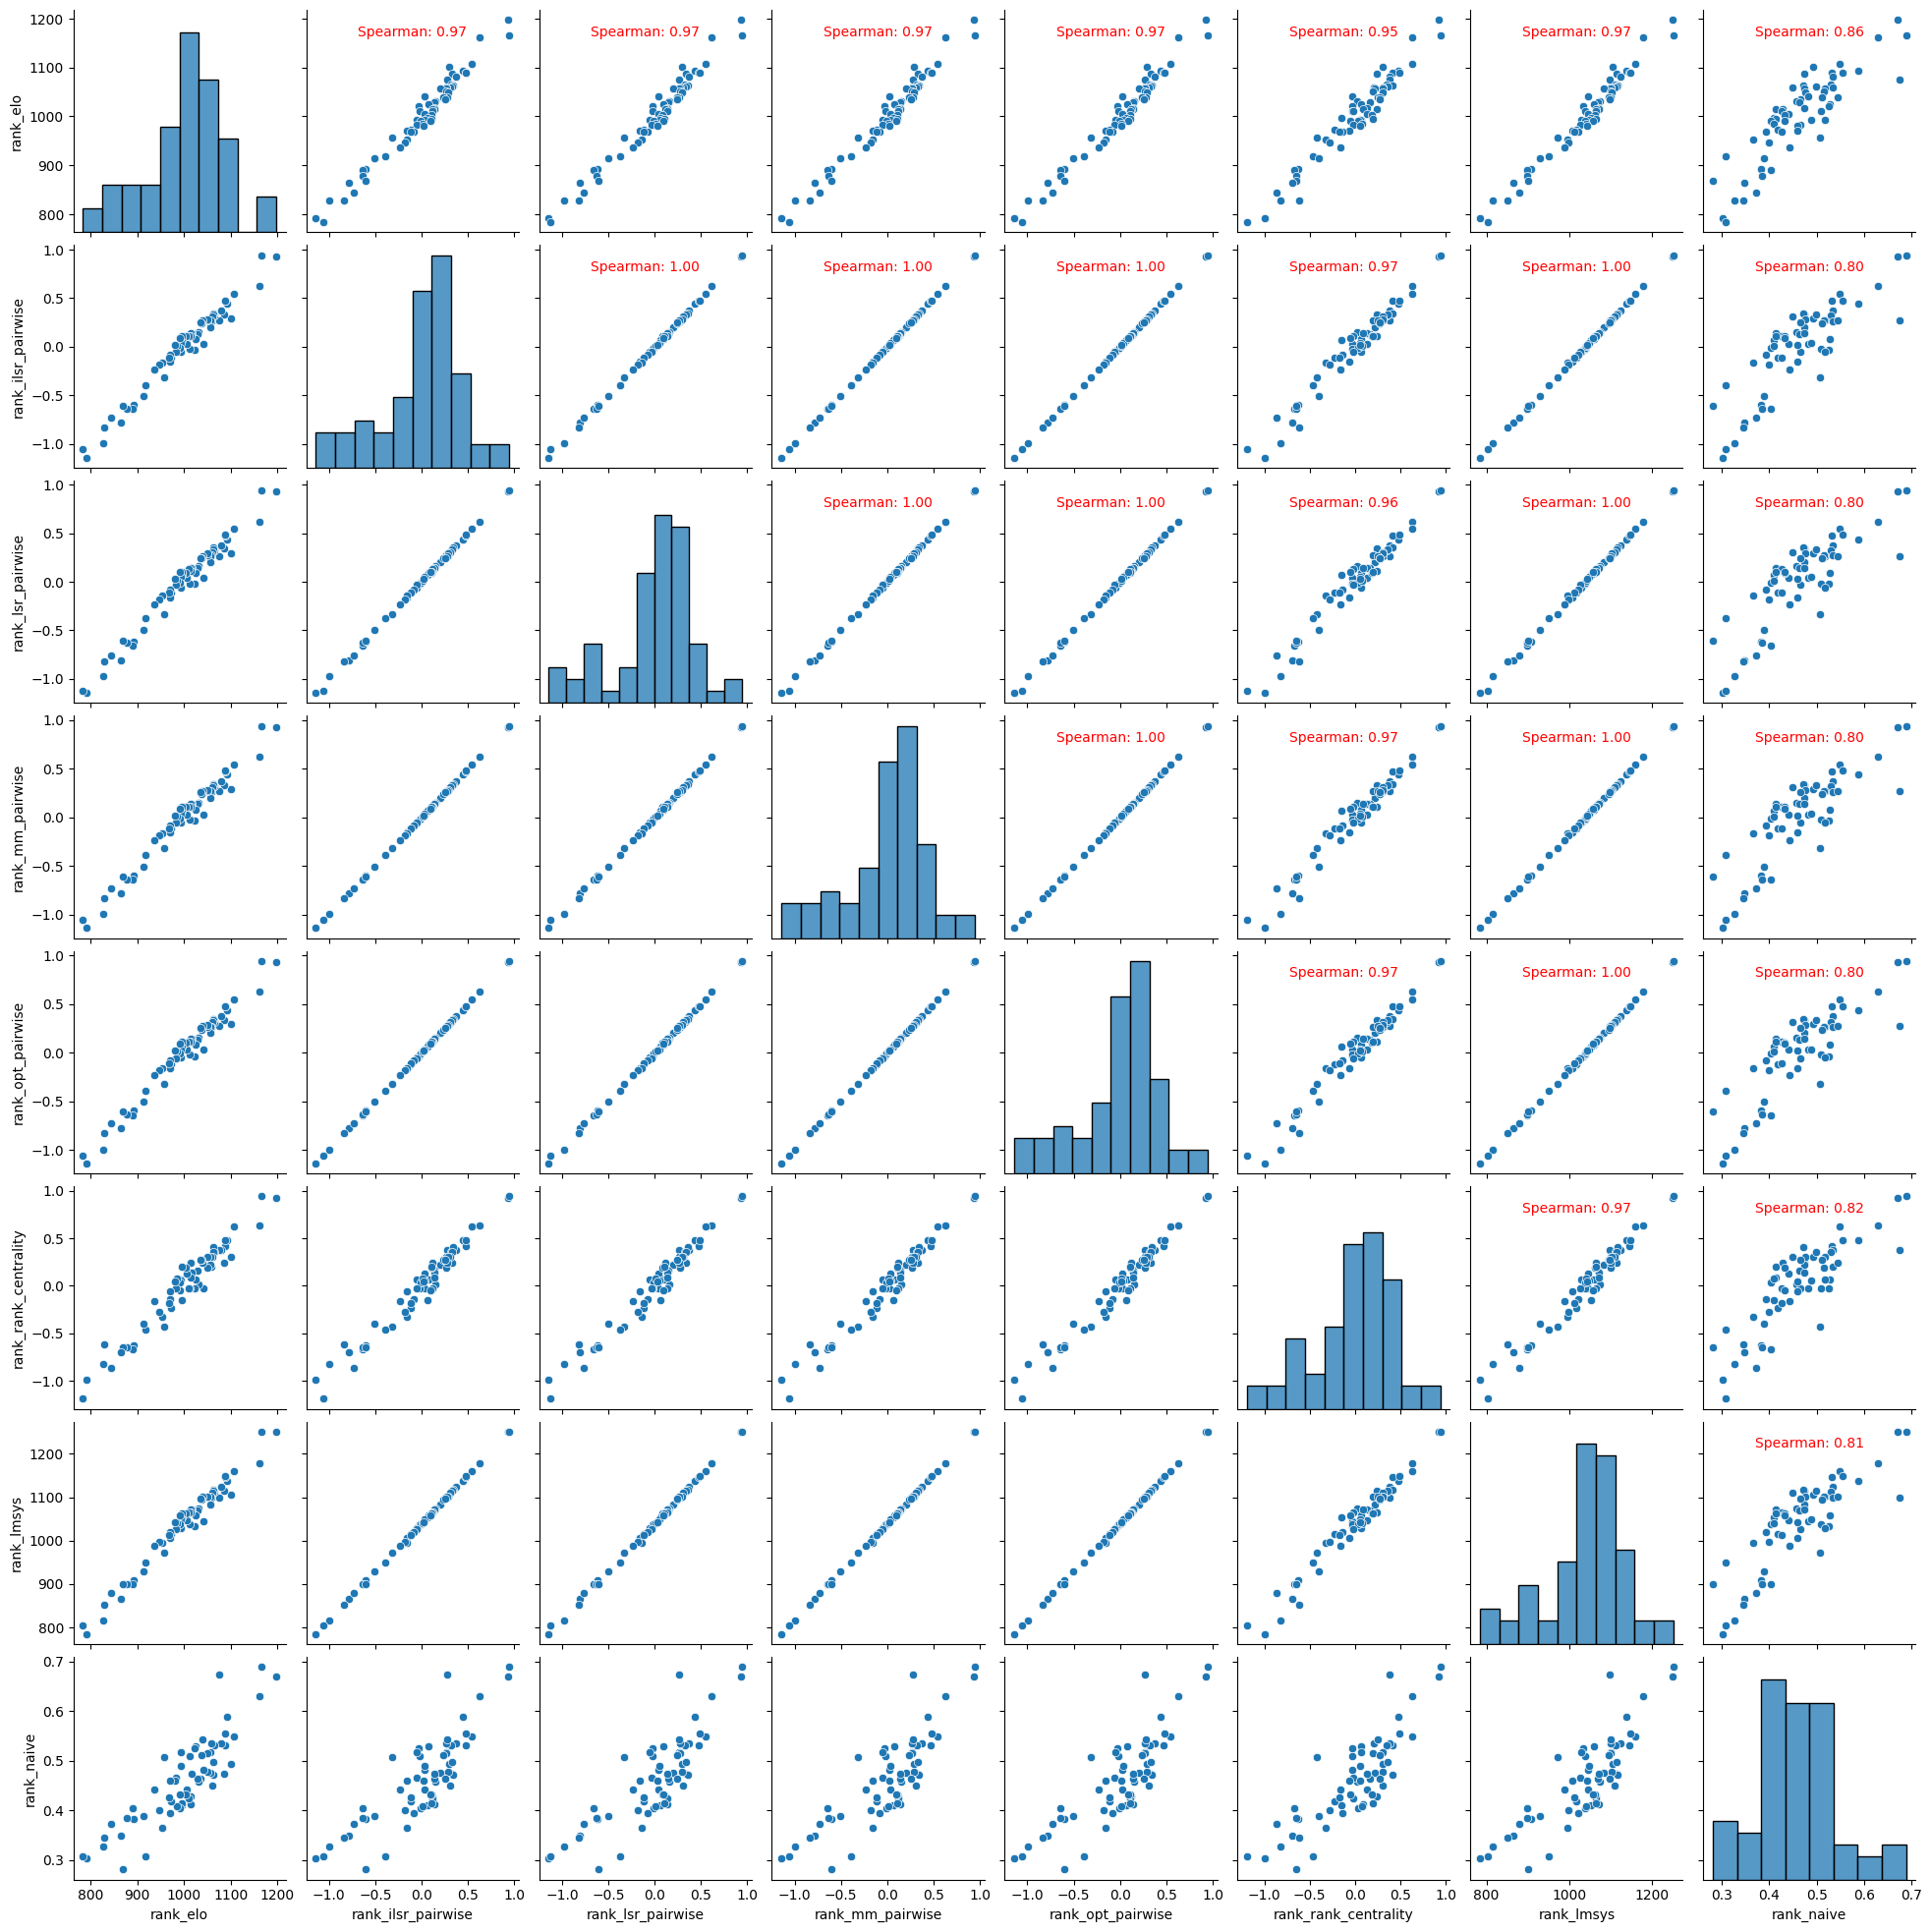

In [30]:
# Calculate the correlation between the ranks of the models in the different leaderboards
merged_df = pd.merge(elo_leaderboard_df, choix_leaderboard_df, on="model", suffixes=("_elo", "_choix"))
merged_df.drop(columns=["annotation"], inplace=True)
merged_df = pd.merge(merged_df, leaderboard_lmsys_df, on="model")
merged_df = pd.merge(merged_df, naive_leaderboard_df, on="model")
correlation_matrix = merged_df[[c for c in merged_df.columns if "rank" in c]].corr(method="spearman")

# Annotate the pairplot with the Spearman correlation
pairplot = sns.pairplot(merged_df)
for i, j in zip(*np.triu_indices_from(pairplot.axes, 1), strict=True):
    pairplot.axes[i, j].annotate(
        f"Spearman: {correlation_matrix.iloc[i, j]:.2f}",
        xy=(0.5, 0.9),
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize=10,
        color="red",
    )

In [40]:
merged_df.sort_values(by="rank_ilsr_pairwise", ascending=False).head(5)[
    ["model", "rank_elo", "rank_ilsr_pairwise"]
]

,model,rank_elo,rank_ilsr_pairwise
1,gpt-4-1106-preview,1165.513834,0.942433
0,gpt-4-0125-preview,1197.760690,0.929538
2,gpt-4-0314,1161.512361,0.627837
3,gpt-4-0613,1107.633191,0.543799
7,qwen1.5-72b-chat,1089.192362,0.478367
